# CEO-Request Challenge

## 1. Sorun Tanımının Özeti

❓ **Olist kârını nasıl artırabilir?** ❓

### P&L Kuralları

#### Revenues  (Gelirler )
**Sales fees:** Olist, teslim edilen her order’ın ürün fiyatı üzerinden (freight hariç) **%10 pay** alır.  
**Subscription fees:** Olist, seller başına ayda **80 BRL** ücret alır.

#### Costs (Maliyetler)
Kötü review’lara (<= 3 stars) sahip orders için _tahmini_ **reputation costs**  

💡 Uzun vadede kötü customer experience iş açısından sonuçlara yol açar: düşük tekrar satın alma oranı, anında customer support maliyeti, refunds veya olumsuz word of mouth iletişimi. Her kötü review için parasal bir cost varsayımı yapıyoruz:

```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist'in total cumulated IT Costs değeri, platforma şimdiye kadar katılmış toplam seller sayısının karekökü ile, şimdiye kadar satılmış toplam birikimli item sayısının karekökü oranında ölçeklenir.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  

Olist'in data team’i bize bu scaling parameter’ları için şu değerleri verdi:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Yönetilen seller sayısı da, sales transaction sayısı da IT systems için maliyetlidir.
💡 Ancak karekök kullanımı scale-effects’i gösterir: IT-system’ler büyüdükçe daha verimli olma eğilimindedir.
💡 Alpha > Beta olması, Olist’in çok item satan az sayıda seller ile çalıştığında, bunun tersi senaryoya göre daha düşük IT Cost’a sahip olduğu anlamına gelir.

1000 sellers ve toplam 100 items satışıyla toplam IT cost 109,624 BRL olur

100 sellers ve toplam 1000 items satışıyla toplam IT cost 62,507 BRL olur

Son olarak, IT department size marketplace’in kuruluşundan bu yana birikmiş IT costs toplamının 500,000 BRL olduğunu da iletti.

Şimdi, bu IT cost formülünü biraz daha iyi anlamak için bir simulation çalıştıralım. Kod üzerinde zaman harcamanıza gerek yok, sadece ortaya çıkan chart’lara bakın.

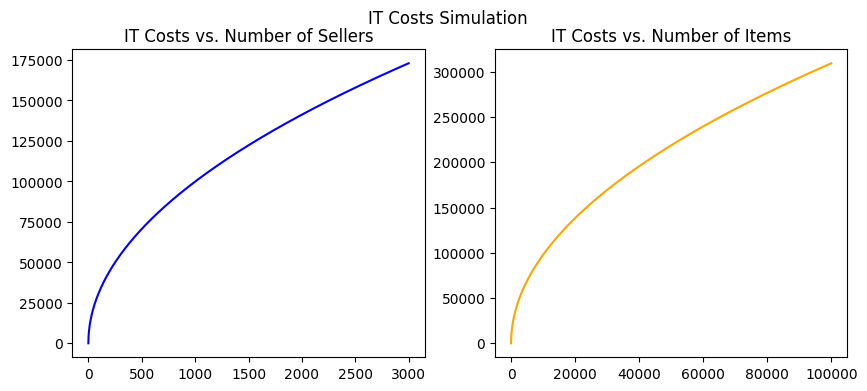

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alpha = 3157.27
beta = 978.23

x_sellers = np.arange(3_000)
y_it_costs_sellers = alpha * x_sellers ** 0.5

x_items = np.arange(100_000)
y_it_costs_items = beta * x_items ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_sellers, y_it_costs_sellers, label='IT costs per seller', color='blue')
plt.title('IT Costs vs. Number of Sellers')
plt.subplot(1, 2, 2)
plt.plot(x_items, y_it_costs_items, label='IT costs per item', color='orange')
plt.title('IT Costs vs. Number of Items')
plt.suptitle('IT Costs Simulation');

### Key Findings, so far

- `wait_time`, düşük review_score’ların arkasındaki en önemli faktördür.  
- `wait_time`, seller’ın `delay_to_carrier` süresi + `carrier_delivery_time` toplamından oluşur.  
- Carrier’ın delivery time’ı Olist’in doğrudan kontrolünde olmadığı için, bunu iyileştirmek hızlı kazanım sağlayacak bir öneri değildir.  
- Buna karşılık, daha iyi bir `seller` seçimi `delay_to_carrier` değerini olumlu şekilde etkileyebilir ve Olist üzerindeki kötü `review_scores` sayısını azaltabilir.  
- Kötü review’lardaki yorumlar, bazılarının seller’dan veya bizzat üründen kaynaklandığını göstermiştir.

💡 Aşağıdaki bölüm 2’deki guided seller analysis ile başlamanızı öneririz.

💪 Ancak bölüm 3 ile başka hipotezleri araştırmakta özgürsünüz.

## 2. Olist, performansları düşük satıcıları pazarından çıkarmalı mı? 🕵🏻
*(önerilen)*

Olist’in marketplace’inden en kötü seller’ları çıkarmanın etkisini analiz etmek için bir **what-if analysis** yapacağız.

👉 **Olist bu seller’ları en baştan hiç kabul etmemiş olsaydı ne olurdu?**  

*(Gerçekte, kimin iyi seller olduğunu önceden bilmek zordur, ancak bu yaklaşımla başlayıp daha sonra iterasyon yapacağız.)*


### 2.1 Veri Hazırlama

Her bir `seller_id` için, başlangıçtan itibaren kümülatif olarak hesaplayın:
- seller’ın getirdiği `revenues`
- seller’ın kötü review’larına bağlı `review_costs`
- ortaya çıkan `profits` (revenues - costs)

👉 İhtiyacınız olan DataFrame’i oluşturmak için adım adım bir strateji yazın.

⚠️ **Sıfırdan başlamayın, mevcut package’ınızı güncelleyin!** 😉

**Çözüm, notebook’a yeni kod yazmakta değil — `.py` dosyalarınızdaki kodu değiştirmektedir.**

`olist` package’ınız içindeki `Seller` class’ından başlayarak:

`get_training_data` method’unu düzenleyin; döndürdüğü DataFrame şu alanları içermeli:
- `revenues`: subscription + sales fees toplamı  
- `cost_of_reviews`: kötü review’lara bağlı toplam cost  
- `profits`: `revenues` - `cost_of_reviews`

`cost_of_reviews` için önce başka bir method’u değiştirmeniz gerekecek. Bununla ilgili olan method hangisi?

In [18]:
from olist.seller import Seller
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,sales_fee,subscription_fee,revenues
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,21.870,320.0,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,1170.307,1120.0,2290.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,15.800,0.0,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,7.999,0.0,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,16.799,0.0,16.799


In [24]:
sellers = Seller().get_training_data()
sellers[['revenues','cost_of_reviews','profits']].head()

,revenues,cost_of_reviews,profits
0,341.870,140.0,201.870
1,2290.307,240.0,2050.307
2,15.800,0.0,15.800
3,7.999,0.0,7.999
4,16.799,100.0,-83.201


### 2.2 IT Maliyetleri Hariç Varsayım Analizi

👉 Gerçek analizi yapma zamanı. İlk olarak bunu IT costs **dahil etmeden** gerçekleştireceğiz.

Adımlarımız:  

1️⃣ Sellers verisini load edin ve profits değerine göre azalan şekilde sıralayın.

2️⃣ Cumulative değerleri hesaplayın:
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için cumulative items sold hesaplayın.

   Pandas ile cumulative sum nasıl hesaplanır, araştırın.

3️⃣ Sonuçlarınızı plot edin ve analiz edin. Pandas’ın `.plot()` method’unu kullanın.

4️⃣ Profits’e göre tutulması gereken optimum seller sayısını belirleyin. (İpucu: `np.argmax` araştırın). Bu kararın etkisi ne olurdu:
   - Net profit (IT costs dahil etmediğimiz için IT costs öncesi)?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

In [50]:
order_profit_df = sellers.sort_values("profits",ascending=False).reset_index(drop=True).copy()

order_profit_df.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,cost_of_reviews,sales_fee,subscription_fee,revenues,profits
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,1.145251,222776.05,0.561798,0.095506,4.132022,5170.0,22277.605,960.0,23237.605,18067.605
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,1.011905,176431.87,0.629851,0.101493,4.214925,4700.0,17643.187,1680.0,19323.187,14623.187
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,1.001709,194042.03,0.676420,0.086059,4.339071,6510.0,19404.203,1600.0,21004.203,14494.203
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,1.054217,79284.55,0.692771,0.066265,4.421687,1520.0,7928.455,880.0,8808.455,7288.455
4,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,23.0,521,542,1.040307,128111.19,0.629126,0.112621,4.194175,7500.0,12811.119,1840.0,14651.119,7151.119


In [86]:
order_profit_df["cum_revenues"] = order_profit_df['revenues'].cumsum()
order_profit_df["cum_profits"] = order_profit_df['profits'].cumsum()
order_profit_df["cum_items"] = order_profit_df['quantity'].cumsum()
order_profit_df["cum_sellers"] = np.arange(1, len(order_profit_df) + 1)

order_profit_df.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,review_score,cost_of_reviews,sales_fee,subscription_fee,revenues,profits,cum_revenues,cum_profits,cum_items,cum_sellers
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,...,4.132022,5170.0,22277.605,960.0,23237.605,18067.605,23237.605,18067.605,410,1
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,...,4.214925,4700.0,17643.187,1680.0,19323.187,14623.187,42560.792,32690.792,750,2
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,...,4.339071,6510.0,19404.203,1600.0,21004.203,14494.203,63564.995,47184.995,1336,3
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,...,4.421687,1520.0,7928.455,880.0,8808.455,7288.455,72373.450,54473.450,1511,4
4,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,23.0,521,542,...,4.194175,7500.0,12811.119,1840.0,14651.119,7151.119,87024.569,61624.569,2053,5


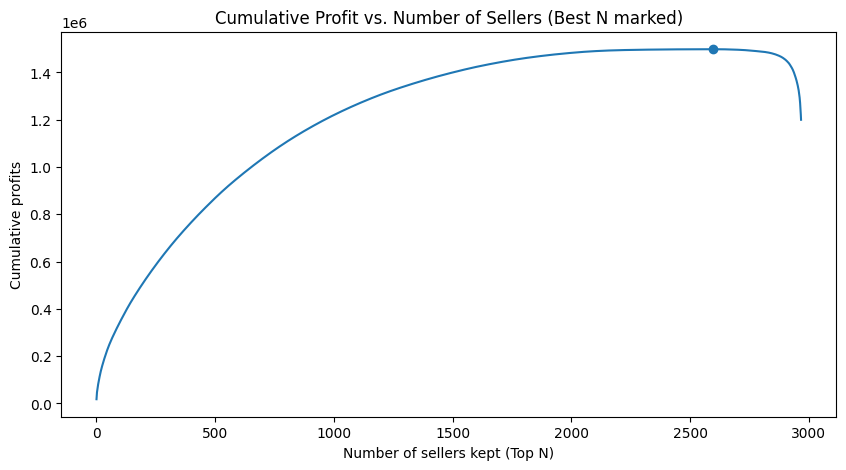

Best N: 2598 , Best cumulative profit: 1497961.04


In [87]:
best_idx = order_profit_df["cum_profits"].values.argmax()
best_n = order_profit_df.loc[best_idx, "cum_sellers"]
best_profit = order_profit_df.loc[best_idx, "cum_profits"]

plt.figure(figsize=(10,5))
plt.plot(order_profit_df["cum_sellers"], order_profit_df["cum_profits"])
plt.scatter([best_n], [best_profit])
plt.title("Cumulative Profit vs. Number of Sellers (Best N marked)")
plt.xlabel("Number of sellers kept (Top N)")
plt.ylabel("Cumulative profits")
plt.show()

print("Best N:", best_n, ", Best cumulative profit:", round(best_profit,2))


In [49]:
order_profit_df[order_profit_df['cum_sellers']==best_n]

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,review_score,cost_of_reviews,sales_fee,subscription_fee,revenues,profits,cum_revenues,cum_profits,cum_items,cum_sellers
2597,e819bcfade7b5d88a27325eb6cfd62c5,guarulhos,SP,0.0,8.968804,2018-07-20 14:45:19,2018-08-20 23:49:16,1.0,5,11,...,4.2,100.0,20.29,80.0,100.29,0.29,2336541.039,1497961.039,67719,2598


### 2.3 IT maliyetleri ile varsayımsal analiz (İsteğe bağlı)

👉 Bu kez IT costs dahil edilerek gerçek analizi yapma zamanı.

Adımlarımız şunlar:  

1️⃣ İki parametreye göre IT costs hesaplayan bir function yazın: seller sayısı ve item sayısı. Temelde matematiksel formülü Python kullanarak yazmanız yeterli.

2️⃣ Sellers verisini load edin ve (IT costs öncesi) kârlarına göre azalan şekilde sıralayın.

3️⃣ Cumulative değerleri hesaplayın (önceki kodu yeniden kullanın):
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için toplam satılan item miktarının cumulative değerini hesaplayın.  

4️⃣ IT costs etkisini hesaplayın:
   - 1️⃣. adımda yazdığınız function’ı kullanarak her satır için cumulative IT cost ekleyin.
   - IT costs sonrası net profit’i hesaplayın.

5️⃣ Sonuçlarınızı plot edin ve analiz edin.

6️⃣ Bu kez IT costs sonrası kârları baz alarak tutulması gereken optimum seller sayısını belirleyin. Bu kararın etkisi ne olurdu:
   - IT costs sonrası net profit?
   - IT costs öncesi net profit?
   - IT costs?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

Analizinizde IT costs ne kadar önemliydi?


In [53]:
def it_cost(n_sellers, n_items):
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)


In [77]:
cols = [
    "cum_sellers", "profits", "revenues", "quantity", "cum_items", "cum_it_cost", "cum_profits", "cum_revenues", 'cum_profits_after_it_cost'
]

df = sellers.sort_values('profits',ascending=False).reset_index(drop=True)
df['cum_revenues'] = df['revenues'].cumsum()
df['cum_profits'] = df['profits'].cumsum()
df['cum_items'] = df['quantity'].cumsum()
df['cum_sellers'] = np.arange(1, len(df)+1)
df['cum_it_cost'] = it_cost(n_sellers=df['cum_sellers'],n_items=df['cum_items'])
df['cum_profits_after_it_cost'] = df['cum_profits'] - df['cum_it_cost']

df[cols].head()


,cum_sellers,profits,revenues,quantity,cum_items,cum_it_cost,cum_profits,cum_revenues,cum_profits_after_it_cost
0,1,18067.605,23237.605,410,410,22964.917828,18067.605,23237.605,-4897.312828
1,2,14623.187,19323.187,340,750,31254.985925,32690.792,42560.792,1435.806075
2,3,14494.203,21004.203,586,1336,41224.163282,47184.995,63564.995,5960.831718
3,4,7288.455,8808.455,175,1511,44339.889079,54473.450,72373.450,10133.560921
4,5,7151.119,14651.119,542,2053,51383.513743,61624.569,87024.569,10241.055257


In [91]:
best_idx_it = df["cum_profits_after_it_cost"].values.argmax()
best_row_it = df.loc[best_idx_it, :]
best_row_it[["cum_sellers","cum_profits_after_it_cost","cum_profits","cum_it_cost","cum_revenues","cum_items"]]


cum_sellers                            2139
cum_profits_after_it_cost    1093618.722737
cum_profits                     1491818.838
cum_it_cost                   398200.115263
cum_revenues                    2314748.838
cum_items                             66456
Name: 2138, dtype: object

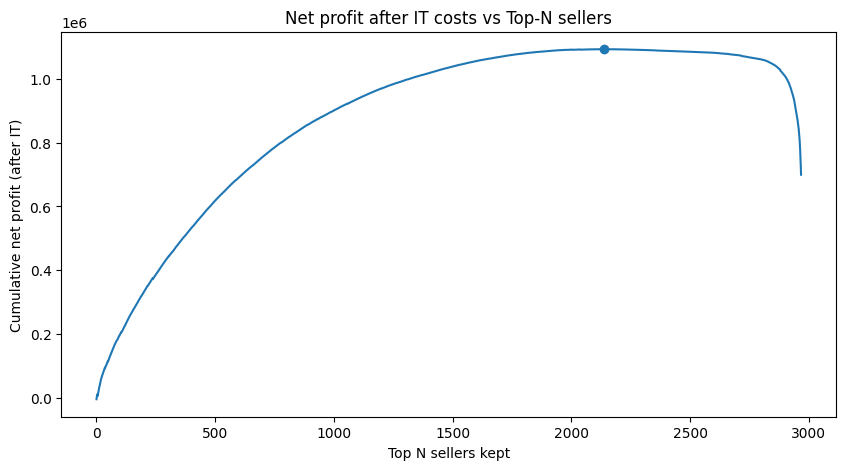

In [92]:
plt.figure(figsize=(10,5))
plt.plot(df["cum_sellers"], df["cum_profits_after_it_cost"])
plt.scatter([best_row_it["cum_sellers"]], [best_row_it["cum_profits_after_it_cost"]])
plt.xlabel("Top N sellers kept")
plt.ylabel("Cumulative net profit (after IT)")
plt.title("Net profit after IT costs vs Top-N sellers")
plt.show()


## CEO Summary (What-If: düşük performanslı seller’ları çıkarmak)

**Amaç:** Olist kârını artırmak için “en düşük performanslı seller’ları” platformdan çıkarmanın etkisini ölçmek.

### P&L Tanımı (seller bazında)
- **Revenues** = %10 × `sales` + 80 BRL × `months_on_olist`
- **Costs (reputation)** = `cost_of_reviews` (1★=100, 2★=50, 3★=40; 4–5★=0)
- **Profits** = `revenues` − `cost_of_reviews`

### Yöntem (What-If)
- Seller’ları `profits` değerine göre **azalan** sıraladık.
- “Top-N seller tutarsak” senaryosunu kümülatif olarak simüle ettik ve aşağıdaki metrikleri hesapladık:
  - `cum_revenues`, `cum_profits`, `cum_items`, `cum_sellers`

---

## Sonuç 1 — IT maliyeti hariç (2.2)
- **Optimum Top-N (IT yok):** **2,598 seller**
- **Kümülatif kâr (IT öncesi):** **1,497,961.04 BRL**

> Bu noktadan sonra daha fazla seller eklemek toplam kârı düşürüyor (marjinal seller’lar negatif / düşük katkı).

---

## Sonuç 2 — IT maliyeti dahil (2.3)
IT cost fonksiyonu:
\[
IT\_cost = \alpha \sqrt{n\_sellers} + \beta \sqrt{n\_items}
\quad (\alpha=3157.27,\ \beta=978.23)
\]

- **Optimum Top-N (IT dahil):** **2,139 seller**
- Bu noktada:
  - **IT öncesi kâr (`cum_profits`):** **1,491,818.839 BRL**
  - **IT cost (`cum_it_cost`):** **398,200.115 BRL**
  - **IT sonrası net kâr:** **1,093,618.723 BRL**
  - **Total revenues:** **2,314,748.839 BRL**
  - **Items sold:** **66,456**

> IT maliyeti eklendiğinde optimum seller sayısı **2,598 → 2,139** düşüyor.  
> Yani IT, net kârı azaltmakla kalmıyor; “kaç seller tutmalıyız?” kararını da değiştiriyor.

---

## Öneri
- IT maliyeti dikkate alındığında, kârlılığı maksimize etmek için **Top 2,139 seller** seviyesinde kalmak en iyi görünüyor.
- Bu bulguyu operasyonel politikaya çevirmek için:
  - yeni seller onboarding’de minimum kalite eşiği / probation,
  - düşük performanslı seller’lar için iyileştirme planı veya kademeli çıkış
  önerilir.


## 3. Diğer Yaklaşımları Araştırın 🕵️
*(isteğe bağlı)*

- Olist, en kötü performans gösteren ürünleri/kategorileri pazarından tamamen kaldırmalı mı?
- Olist, birkaç aylık balayı döneminden sonra, sadece sürekli olarak düşük performans gösteren satıcıları kaldırmalı mı?
- Olist, satıcılardan ürün listelerine belirli bilgileri eklemelerini zorunlu kılmalı mı?
- Olist, günün belirli saatlerinde müşterilerden satın alma onayı istemeli mi?
- Olist, gecikmeleri önlemek için belirli eyaletler arasındaki satıcı/müşteri çiftlerini kısıtlamalı mı?
- Olist, bazı maliyet varsayımları önerilerek yeni satıcılar kazanmalı mı?
- ...

## Sıra Sende!

## Olist, günün belirli saatlerinde müşterilerden satın alma onayı istemeli mi?

### Adım 1 — Veriyi yükleme (orders, reviews, payments)
Bu CEO sorusunda order-level bir analiz yapacağım. Bunun için `Olist().get_data()` ile gelen sözlükten üç tabloyu alıyorum:
- `orders`: sipariş zamanı, onay zamanı ve sipariş statüsü (saat bazlı analiz için temel kaynak)
- `order_reviews`: memnuniyet sinyali (review_score)
- `order_payments`: ödeme tipi ve tutar (saat etkisini açıklayabilecek önemli bir confounder)

In [180]:
from olist.data import Olist  # Olist veri setini yüklemeye yarayan sınıfı içe aktarır

data = Olist().get_data()     # Tüm tabloları (orders, order_reviews, order_payments vb.) bir dict olarak getirir

df_orders   = data["orders"].copy()          # orders tablosunu DataFrame olarak alır (orijinali bozmamak için copy)
df_reviews  = data["order_reviews"].copy()   # order_reviews tablosunu DataFrame olarak alır
df_payments = data["order_payments"].copy()  # order_payments tablosunu DataFrame olarak alır

print("df_orders columns:\n", df_orders.columns)        # orders DataFrame'inin kolon isimlerini yazdırır
print("\ndf_reviews columns:\n", df_reviews.columns)    # reviews DataFrame'inin kolon isimlerini yazdırır
print("\ndf_payments columns:\n", df_payments.columns)  # payments DataFrame'inin kolon isimlerini yazdırır


df_orders columns:
 Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

df_reviews columns:
 Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

df_payments columns:
 Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


In [181]:
print("orders shape:", df_orders.shape)    # orders tablosunun (satır, kolon) sayısını yazdırır
print("reviews shape:", df_reviews.shape)  # reviews tablosunun (satır, kolon) sayısını yazdırır
print("payments shape:", df_payments.shape)# payments tablosunun (satır, kolon) sayısını yazdırır

print("\nreview per order (top 5):")       # order başına kaç review satırı var? (en çok olan ilk 5 order)
print(df_reviews["order_id"].value_counts().head())  # order_id frekanslarını sayar ve ilk 5’ini gösterir

print("\npayments per order (top 5):")     # order başına kaç payment satırı var? (en çok olan ilk 5 order)
print(df_payments["order_id"].value_counts().head()) # order_id frekanslarını sayar ve ilk 5’ini gösterir


orders shape: (99441, 8)
reviews shape: (99224, 7)
payments shape: (103886, 5)

review per order (top 5):
order_id
c88b1d1b157a9999ce368f218a407141    3
8e17072ec97ce29f0e1f111e598b0c85    3
df56136b8031ecd28e200bb18e6ddb2e    3
03c939fd7fd3b38f8485a0f95798f1f6    3
5cb890a68b91b6158d69257e4e2bc359    2
Name: count, dtype: int64

payments per order (top 5):
order_id
fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
285c2e15bebd4ac83635ccc563dc71f4    22
895ab968e7bb0d5659d16cd74cd1650c    21
fedcd9f7ccdc8cba3a18defedd1a5547    19
Name: count, dtype: int64


### Adım 2 — Zaman feature engineering
`orders` tablosundaki timestamp kolonlarını datetime’a çevirip saat bazlı analiz için yeni değişkenler üretiyorum:
- `purchase_hour`: siparişin verildiği saat (0–23)
- `purchase_dow`: haftanın günü (0=Monday)
- `approval_delay_hours`: sipariş zamanı ile onay zamanı arasındaki fark (saat cinsinden)

In [182]:
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], errors='coerce')  # satın alma zamanını datetime'a çevirir; çevrilemeyenleri NaT yapar
df_orders['order_approved_at'] = pd.to_datetime(df_orders['order_approved_at'], errors='coerce')              # onay zamanını datetime'a çevirir; çevrilemeyenleri NaT yapar

df_orders['purchase_hour'] = df_orders['order_purchase_timestamp'].dt.hour       # satın alma zamanından saat bilgisini (0–23) çıkarır
df_orders['purchase_dow'] = df_orders['order_purchase_timestamp'].dt.dayofweek   # satın alma zamanından haftanın günü bilgisini çıkarır (0=Mon, 6=Sun)

df_orders["approval_delay_hours"] = (                                             # satın alma ile onay arasındaki farkı saat cinsinden hesaplar
    (df_orders["order_approved_at"] - df_orders["order_purchase_timestamp"])       # timedelta farkı (approved - purchase)
      .dt.total_seconds() / 3600                                                   # saniyeye çevirip 3600'e bölerek saate çevirir
).round(2)                                                                         # daha okunur olması için 2 ondalık basamağa yuvarlar

print(df_orders.head(3))                                                           # ilk 3 satırı kontrol amaçlı basar
print(df_orders['purchase_hour'].value_counts().sort_index())                      # saat dağılımını (0–23) sıralı şekilde gösterir
print("Min hour:", df_orders["purchase_hour"].min())                               # görülen en küçük saat değerini yazar
print("Max hour:", df_orders["purchase_hour"].max())                               # görülen en büyük saat değerini yazar
print("NaN hour rate:", df_orders["purchase_hour"].isna().mean())                  # saat çıkarılamayan satır oranını (NaN) verir


                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  purchase_hour  purchase_dow  \
0           2017-10-18 00:00:00             10             0   
1           2018-08-13 00:00:00             20             1   
2    

🧺 Bu defteri düzenli tutun! 

🗣 📊 Bu `Communicate`  ünitesinin sonunda, en sevdiğiniz TA'ya görüşlerinizi sunacaksınız 💪

### Adım 3 — Review verisini order-level’a indirgeme (merge şişmesini engelleme)
`order_reviews` tablosunda bazı siparişler için birden fazla review kaydı bulunabildiği için, doğrudan `orders` ile merge etmek satır sayısını artırabilir (row explosion).  
Bu yüzden review verisini **order-level** hale getiriyorum: her `order_id` için tek bir `review_score` bırakacak şekilde tekilleştiriyorum.

Bu adımda ayrıca saat bazlı analizde kullanmak üzere iki sinyal üretiyorum:
- `is_low_review`: `review_score <= 3` olan siparişleri işaretler (kötü deneyim proxy’si)
- `is_five_star`: `review_score == 5` olan siparişleri işaretler (çok iyi deneyim)

Kontrol olarak `order_id` alanının benzersiz (unique) olduğundan emin olarak, bir sonraki adımda güvenli şekilde `orders` tablosu ile birleştireceğim.


In [183]:
reviews_agg = df_reviews[['order_id','review_score']].copy()  # reviews tablosundan sadece order_id ve review_score kolonlarını alır (orijinali bozmamak için copy)

reviews_agg["review_score"] = pd.to_numeric(reviews_agg["review_score"], errors="coerce")  # review_score'u sayısala çevirir; çevrilemeyenleri NaN yapar
reviews_agg = reviews_agg.dropna(subset=['review_score'])                                  # review_score'u boş (NaN) olan satırları atar

reviews_agg = reviews_agg.drop_duplicates(subset=['order_id'])                             # her order_id için tek satır kalacak şekilde tekilleştirir (ilk görüleni tutar)

reviews_agg["is_low_review"]  = (reviews_agg["review_score"] <= 3).astype(int)            # 3 ve altı puanları 1, diğerlerini 0 yapar (low review flag)
reviews_agg["is_five_star"] = (reviews_agg["review_score"] == 5).astype(int)              # 5 puanları 1, diğerlerini 0 yapar (five-star flag)

print(reviews_agg.shape)                                                                   # (satır, kolon) sayısını kontrol eder
print(reviews_agg["order_id"].is_unique)                                                   # order_id'ler unique mi? (True olmalı; merge'de satır şişmesini önler)
display(reviews_agg.head())                                                                # ilk 5 satırı gözle kontrol için gösterir
print(reviews_agg[["is_low_review","is_five_star"]].sum())                                 # flag kolonlarındaki 1'lerin toplamını verir (kaç low review / kaç five-star var)


(98673, 4)
True


,order_id,review_score,is_low_review,is_five_star
0,73fc7af87114b39712e6da79b0a377eb,4,0,0
1,a548910a1c6147796b98fdf73dbeba33,5,0,1
2,f9e4b658b201a9f2ecdecbb34bed034b,5,0,1
3,658677c97b385a9be170737859d3511b,5,0,1
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,1


is_low_review    22610
is_five_star     57019
dtype: int64


### Adım 4 — Payment verisini order-level’a indirgeme (merge şişmesini engelleme)
`order_payments` tablosunda bir sipariş (`order_id`) birden fazla ödeme satırına sahip olabiliyor (taksit / birden çok payment satırı vb.).  
Bu nedenle `orders` ile doğrudan merge etmek satır sayısını artırabilir.

Bu adımda `order_id` bazında gruplayarak payment verisini **order-level** hale getiriyorum ve aşağıdaki özet metrikleri çıkarıyorum:
- `total_payment_value`: siparişe ait toplam ödeme tutarı (`payment_value` toplamı)
- `max_installments`: sipariş içinde görülen en yüksek taksit sayısı (`payment_installments` max)
- `payment_type`: siparişin baskın ödeme türü (mode; mode yoksa ilk görülen değer)

Kontrol olarak `order_id` alanının unique olduğundan emin olup, sonraki adımda bu tabloyu güvenli şekilde `orders` ve `order_reviews` ile birleştireceğim.  
Bu sayede saat bazlı analizde, “saat etkisi mi yoksa ödeme tipi etkisi mi?” ayrımını daha doğru yapabileceğim.


In [187]:
pay = df_payments[["order_id", "payment_value", "payment_installments", "payment_type"]].copy()  # payments tablosundan gerekli kolonları seçer (orijinali bozmamak için copy)

def mode_or_first(s):
    m = s.mode(dropna=True)                      # seride en sık görülen değeri(leri) bulur (NaN'leri saymaz); sonuç bir Series olabilir
    if len(m) > 0:                               # en az bir mode bulunduysa
        return m.iloc[0]                         # ilk mode değerini döndürür (beraberlik varsa tie-break olarak ilkini seçer)
    return s.dropna().iloc[0] if s.notna().any() else np.nan  # mode yoksa: NaN olmayan ilk değeri döndür; tamamen boşsa NaN döndür

pay_agg = (
    pay.groupby("order_id", as_index=False)      # order_id bazında gruplayarak order-level'a indirger
       .agg(
           total_payment_value=("payment_value", "sum"),       # her order için ödeme değerlerini toplar (order toplam ödemesi)
           max_installments=("payment_installments", "max"),   # her order için en yüksek taksit sayısını alır
           payment_type=("payment_type", mode_or_first),       # her order için baskın ödeme türünü (mode) seçer; gerekirse fallback uygular
       )
)

print(pay_agg.shape)                              # (satır, kolon) sayısını kontrol eder; satır sayısı benzersiz order_id sayısı olmalı
print(pay_agg["order_id"].is_unique)              # order_id'ler unique mi? (True olmalı; merge'de satır şişmesini önler)
display(pay_agg.head())                           # ilk 5 satırı gözle kontrol için gösterir
print(pay_agg["payment_type"].value_counts().head())  # en sık görülen ödeme türlerini ve adetlerini hızlıca kontrol eder


(99440, 4)
True


,order_id,total_payment_value,max_installments,payment_type
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,2,credit_card
1,00018f77f2f0320c557190d7a144bdd3,259.83,3,credit_card
2,000229ec398224ef6ca0657da4fc703e,216.87,5,credit_card
3,00024acbcdf0a6daa1e931b038114c75,25.78,2,credit_card
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,3,credit_card


payment_type
credit_card    76132
boleto         19784
voucher         1994
debit_card      1527
not_defined        3
Name: count, dtype: int64


### Adım 5 — Master order-level tabloyu oluşturma (orders + reviews + payments)
Bu adımda analizde kullanacağım ana tabloyu oluşturuyorum: **1 order = 1 satır** olacak şekilde `orders` tablosunu temel alıp, order-level’a indirgediğim `order_reviews` ve `order_payments` özetlerini `order_id` üzerinden birleştiriyorum.

- `orders` ana evren olduğu için merge türü olarak **left join** kullanıyorum. Böylece her sipariş master tabloda kalır; review veya payment bilgisi yoksa ilgili alanlar `NaN` olabilir.
- Merge sonrası en kritik kontrol: **satır sayısının değişmemesi**.  
  Eğer satır sayısı artarsa bu, review/payment tarafında order başına birden fazla satır kaldığını ve merge’in “şiştiğini” gösterir.

Kontrol sonucu: `df_master` satır sayısı `df_orders` ile aynı kaldı (**99441**), yani master tablo güvenli şekilde oluşturuldu.


In [188]:
df_master = pd.merge(df_orders, reviews_agg, on='order_id', how='left')  # orders ana tablo olacak şekilde, reviews_agg'yi order_id üzerinden sol birleştirir (review yoksa NaN kalır)
df_master = pd.merge(df_master, pay_agg, on='order_id', how='left')      # oluşan master tabloya payments agregasyonunu yine order_id üzerinden sol birleştirir (payment yoksa NaN kalır)

print("df_master rows:", df_master.shape[0])                             # master tablonun satır sayısını yazdırır
print("df_orders rows :", df_orders.shape[0])                            # orders tablosunun satır sayısını yazdırır (referans evren)
print("rows equal?    :", df_master.shape[0] == df_orders.shape[0])      # satır sayısı aynı mı? True olmalı (satır şişmesi/çoğalması yok demektir)


df_master rows: 99441
df_orders rows : 99441
rows equal?    : True


### Adım 6 — Saat bazında KPI’lar ve ilk içgörüler (orders + reviews + payments)
Bu adımda CEO sorusunu cevaplamak için `df_master` üzerinden **saat bazlı performans metrikleri** üretiyorum. Amaç: “günün hangi saatlerinde sipariş kalitesi / onay süreci daha problemli?” sorusunu ölçmek ve bu etkinin ödeme tipiyle (payment_type) karışıp karışmadığını görmek.

**1) Outcome değişkenleri**
- `is_problem`: sipariş statüsü `canceled` veya `unavailable` ise 1, aksi 0.  
  (İptal / problem oranını saat bazında takip etmek için)
- `is_low_review`: `review_score <= 3` ise 1. Review yoksa `NaN` bırakıyorum.  
  (Memnuniyet için proxy; review olmayan siparişlerde “bilinmiyor” yaklaşımı)

**2) Saat bazında özet tablo (hourly KPI)**
`purchase_hour` (0–23) kırılımında şu metrikleri hesaplıyorum:
- `n_orders`: saat içindeki sipariş sayısı (güven/örneklem büyüklüğü için)
- `problem_rate`: problemli sipariş oranı (canceled + unavailable)
- `median_approval_delay`: onay gecikmesinin medyanı (saat cinsinden)
- `low_review_rate`: düşük review oranı (<=3), yalnızca review olan siparişler üzerinden

**3) Payment type kırılımı (confounder kontrolü)**
Saat etkisini daha doğru yorumlamak için aynı KPI’ları `purchase_hour × payment_type` bazında da üretiyorum.  
Böylece “gece saatleri kötü görünüyor” ise bunun gerçekten saatten mi yoksa gece daha sık kullanılan ödeme tiplerinden mi kaynaklandığını kontrol edebilirim.

**4) Görselleştirme**
Sonuçları hızlı yorumlamak için:
- `problem_rate` vs `purchase_hour`
- `median_approval_delay` vs `purchase_hour`
- `low_review_rate` vs `purchase_hour`
grafiklerini çiziyorum.

Bu çıktılar, “belirli saatlerde satın alma onayı istemek” politikasının hangi saat/segmentlerde anlamlı olabileceğine dair ilk yönlendirmeyi sağlayacak.


Order status counts:
 order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Overall problem rate (canceled+unavailable): 0.012409368369183738


,purchase_hour,n_orders,problem_rate,median_approval_delay,share_delivered
0,0,2394,0.013367,0.520,0.969507
1,1,1170,0.013675,0.380,0.968376
2,2,510,0.013725,0.390,0.972549
3,3,272,0.018382,0.825,0.952206
4,4,206,0.004854,0.710,0.985437
5,5,188,0.015957,0.810,0.968085
6,6,502,0.017928,0.360,0.952191
7,7,1231,0.010561,0.370,0.974005
8,8,2967,0.009437,0.360,0.979778
9,9,4785,0.015256,0.360,0.971160


,purchase_hour,n_orders,problem_rate,median_approval_delay,share_delivered
3,3,272,0.018382,0.825,0.952206
6,6,502,0.017928,0.360,0.952191
5,5,188,0.015957,0.810,0.968085
9,9,4785,0.015256,0.360,0.971160
10,10,6177,0.015218,0.360,0.967784


,purchase_hour,n_delivered,low_review_rate,n_reviews
4,4,203,0.242574,202
0,0,2321,0.238344,2295
2,2,496,0.232653,490
6,6,478,0.231579,475
1,1,1133,0.222816,1122


,purchase_hour,payment_type,n_orders,problem_rate,median_approval_delay,share_delivered
0,0,boleto,432,0.013889,29.610,0.967593
4,1,boleto,236,0.016949,29.940,0.966102
8,2,boleto,92,0.043478,26.510,0.945652
12,3,boleto,70,0.028571,27.175,0.942857
16,4,boleto,51,0.000000,24.330,1.000000
20,5,boleto,44,0.022727,27.025,0.954545
24,6,boleto,120,0.025000,23.260,0.941667
28,7,boleto,284,0.007042,20.755,0.975352
32,8,boleto,700,0.012857,20.110,0.980000
36,9,boleto,1151,0.019983,19.320,0.967854



Payment type counts:
 payment_type
credit_card    76132
boleto         19784
voucher         1994
debit_card      1527
not_defined        3
Name: count, dtype: int64


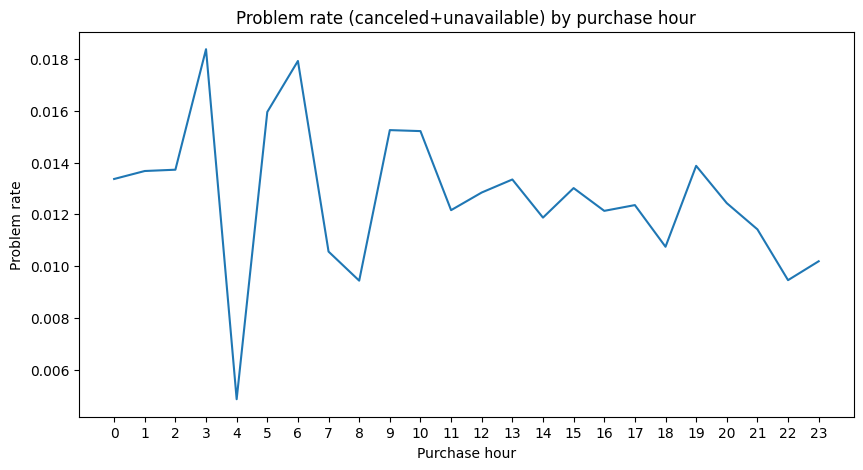

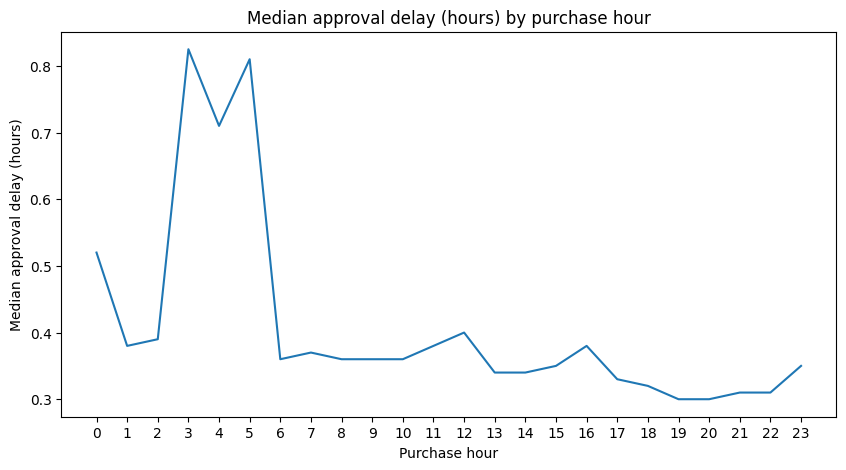

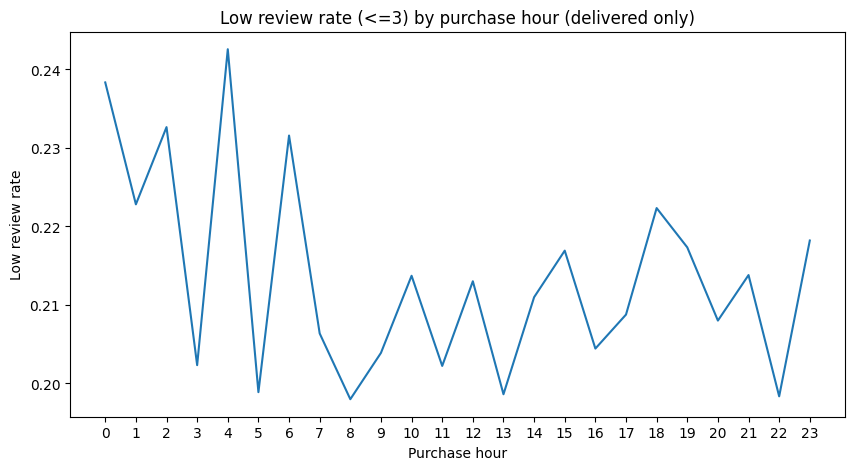

In [189]:
problem_statuses = ["canceled", "unavailable"]
df_master["is_problem"] = df_master["order_status"].isin(problem_statuses).astype(int)

# Review score sadece delivered'da anlamlı olduğu için delivered subset'te low review üreteceğiz
df_master["is_delivered"] = (df_master["order_status"] == "delivered").astype(int)

print("Order status counts:\n", df_master["order_status"].value_counts())
print("\nOverall problem rate (canceled+unavailable):", df_master["is_problem"].mean())

# -------------------------
# 6.2 Saat bazında KPI tablosu (genel)
# -------------------------
hourly = (
    df_master
    .groupby("purchase_hour", as_index=False)
    .agg(
        n_orders=("order_id", "count"),
        problem_rate=("is_problem", "mean"),
        median_approval_delay=("approval_delay_hours", "median"),
        share_delivered=("is_delivered", "mean"),
    )
    .sort_values("purchase_hour")
)

display(hourly.head(10))
display(hourly.sort_values("problem_rate", ascending=False).head(5))

# -------------------------
# 6.2b Saat bazında review KPI (sadece delivered)
# -------------------------
df_delivered = df_master[df_master["order_status"] == "delivered"].copy()

df_delivered["is_low_review"] = np.where(
    df_delivered["review_score"].notna(),
    (df_delivered["review_score"] <= 3).astype(int),
    np.nan
)

hourly_reviews = (
    df_delivered
    .groupby("purchase_hour", as_index=False)
    .agg(
        n_delivered=("order_id", "count"),
        low_review_rate=("is_low_review", "mean"),
        n_reviews=("review_score", lambda s: s.notna().sum()),
    )
    .sort_values("purchase_hour")
)

display(hourly_reviews.sort_values("low_review_rate", ascending=False).head(5))

# -------------------------
# 6.3 Saat x payment_type (stratified) - problem ve approval_delay için
# -------------------------
hourly_pay = (
    df_master
    .groupby(["purchase_hour", "payment_type"], as_index=False)
    .agg(
        n_orders=("order_id", "count"),
        problem_rate=("is_problem", "mean"),
        median_approval_delay=("approval_delay_hours", "median"),
        share_delivered=("is_delivered", "mean"),
    )
    .sort_values(["payment_type", "purchase_hour"])
)

display(hourly_pay.head(15))
print("\nPayment type counts:\n", df_master["payment_type"].value_counts())

# -------------------------
# 6.4 Basit plotlar
# -------------------------
plt.figure(figsize=(10, 5))
plt.plot(hourly["purchase_hour"], hourly["problem_rate"])
plt.title("Problem rate (canceled+unavailable) by purchase hour")
plt.xlabel("Purchase hour")
plt.ylabel("Problem rate")
plt.xticks(range(0, 24))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(hourly["purchase_hour"], hourly["median_approval_delay"])
plt.title("Median approval delay (hours) by purchase hour")
plt.xlabel("Purchase hour")
plt.ylabel("Median approval delay (hours)")
plt.xticks(range(0, 24))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(hourly_reviews["purchase_hour"], hourly_reviews["low_review_rate"])
plt.title("Low review rate (<=3) by purchase hour (delivered only)")
plt.xlabel("Purchase hour")
plt.ylabel("Low review rate")
plt.xticks(range(0, 24))
plt.show()

Order status counts:
 order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Overall problem rate (canceled+unavailable): 0.012409368369183738


,purchase_hour,n_orders,problem_rate,median_approval_delay,share_delivered
0,0,2394,0.013367,0.520,0.969507
1,1,1170,0.013675,0.380,0.968376
2,2,510,0.013725,0.390,0.972549
3,3,272,0.018382,0.825,0.952206
4,4,206,0.004854,0.710,0.985437
5,5,188,0.015957,0.810,0.968085
6,6,502,0.017928,0.360,0.952191
7,7,1231,0.010561,0.370,0.974005
8,8,2967,0.009437,0.360,0.979778
9,9,4785,0.015256,0.360,0.971160


,purchase_hour,n_orders,problem_rate,median_approval_delay,share_delivered
3,3,272,0.018382,0.825,0.952206
6,6,502,0.017928,0.360,0.952191
5,5,188,0.015957,0.810,0.968085
9,9,4785,0.015256,0.360,0.971160
10,10,6177,0.015218,0.360,0.967784


,purchase_hour,n_delivered,low_review_rate,n_reviews
4,4,203,0.242574,202
0,0,2321,0.238344,2295
2,2,496,0.232653,490
6,6,478,0.231579,475
1,1,1133,0.222816,1122


,purchase_hour,payment_type,n_orders,problem_rate,median_approval_delay,share_delivered
0,0,boleto,432,0.013889,29.610,0.967593
4,1,boleto,236,0.016949,29.940,0.966102
8,2,boleto,92,0.043478,26.510,0.945652
12,3,boleto,70,0.028571,27.175,0.942857
16,4,boleto,51,0.000000,24.330,1.000000
20,5,boleto,44,0.022727,27.025,0.954545
24,6,boleto,120,0.025000,23.260,0.941667
28,7,boleto,284,0.007042,20.755,0.975352
32,8,boleto,700,0.012857,20.110,0.980000
36,9,boleto,1151,0.019983,19.320,0.967854



Payment type counts:
 payment_type
credit_card    76132
boleto         19784
voucher         1994
debit_card      1527
not_defined        3
Name: count, dtype: int64


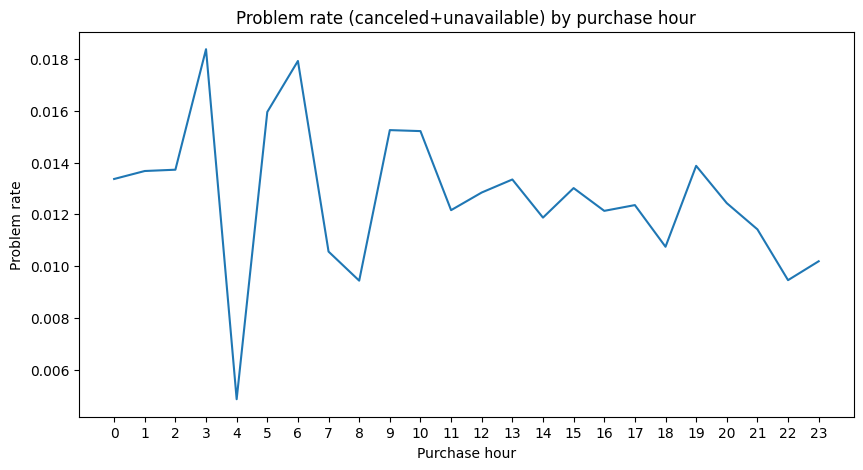

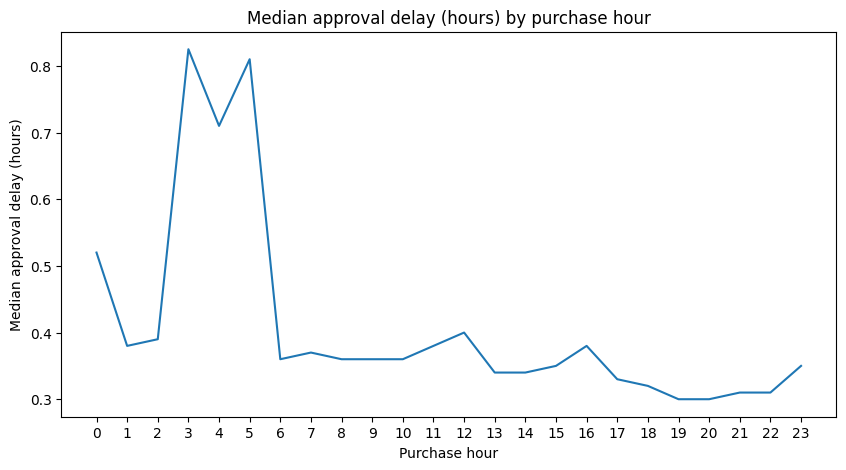

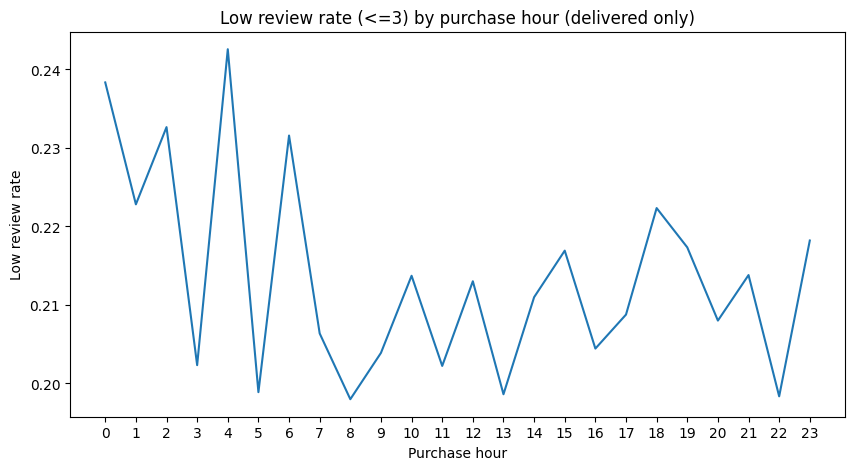

In [190]:
problem_statuses = ["canceled", "unavailable"]                                        # “problemli” sayacağımız sipariş durumlarını tanımlar
df_master["is_problem"] = df_master["order_status"].isin(problem_statuses).astype(int) # order_status bu listede mi? -> True/False; int'e çevirip 1/0 flag yapar

# Review score sadece delivered'da anlamlı olduğu için delivered subset'te low review üreteceğiz
df_master["is_delivered"] = (df_master["order_status"] == "delivered").astype(int)    # teslim edilen siparişleri 1, diğerlerini 0 yapar (delivered flag)

print("Order status counts:\n", df_master["order_status"].value_counts())             # order_status kategorilerinin adetlerini kontrol eder
print("\nOverall problem rate (canceled+unavailable):", df_master["is_problem"].mean()) # tüm siparişler içinde problemli sipariş oranını verir (1/0 ortalaması)

# -------------------------
# 6.2 Saat bazında KPI tablosu (genel)
# -------------------------
hourly = (
    df_master                                                                             # tüm siparişleri baz alır (orders evreni)
    .groupby("purchase_hour", as_index=False)                                             # satın alma saatine göre grupla (0-23)
    .agg(
        n_orders=("order_id", "count"),                                                   # saat başına sipariş sayısı
        problem_rate=("is_problem", "mean"),                                              # saat başına problem oranı (1/0 ortalaması)
        median_approval_delay=("approval_delay_hours", "median"),                         # saat başına median onay gecikmesi (saat)
        share_delivered=("is_delivered", "mean"),                                         # saat başına delivered oranı (1/0 ortalaması)
    )
    .sort_values("purchase_hour")                                                         # saatleri 0'dan 23'e sıralar
)

display(hourly.head(10))                                                                  # ilk 10 saatin özetini görsel kontrol için gösterir
display(hourly.sort_values("problem_rate", ascending=False).head(5))                      # problem oranı en yüksek 5 saati gösterir

# -------------------------
# 6.2b Saat bazında review KPI (sadece delivered)
# -------------------------
df_delivered = df_master[df_master["order_status"] == "delivered"].copy()                 # sadece delivered siparişleri filtreler (review_score burada anlamlı)

df_delivered["is_low_review"] = np.where(                                                 # review var/yok durumunu koruyarak low review flag üretir
    df_delivered["review_score"].notna(),                                                 # review_score mevcutsa
    (df_delivered["review_score"] <= 3).astype(int),                                      # 3 ve altı ise 1, değilse 0
    np.nan                                                                                # review yoksa NaN bırak (ortalama alırken “yok”ları katmamak için)
)

hourly_reviews = (
    df_delivered
    .groupby("purchase_hour", as_index=False)                                             # delivered siparişleri satın alma saatine göre grupla
    .agg(
        n_delivered=("order_id", "count"),                                                # saat başına delivered sipariş sayısı
        low_review_rate=("is_low_review", "mean"),                                        # saat başına low review oranı (NaN'ler otomatik dışarıda kalır)
        n_reviews=("review_score", lambda s: s.notna().sum()),                            # saat başına kaç delivered siparişte review var? (NaN olmayanları sayar)
    )
    .sort_values("purchase_hour")                                                         # saatleri sıraya koyar
)

display(hourly_reviews.sort_values("low_review_rate", ascending=False).head(5))           # low review oranı en yüksek 5 saati gösterir

# -------------------------
# 6.3 Saat x payment_type (stratified) - problem ve approval_delay için
# -------------------------
hourly_pay = (
    df_master
    .groupby(["purchase_hour", "payment_type"], as_index=False)                           # saat + ödeme tipi kırılımında grupla
    .agg(
        n_orders=("order_id", "count"),                                                   # saat+payment_type bazında sipariş sayısı
        problem_rate=("is_problem", "mean"),                                              # saat+payment_type bazında problem oranı
        median_approval_delay=("approval_delay_hours", "median"),                         # saat+payment_type bazında median onay gecikmesi
        share_delivered=("is_delivered", "mean"),                                         # saat+payment_type bazında delivered oranı
    )
    .sort_values(["payment_type", "purchase_hour"])                                       # her payment_type içinde saat sırasına dizer
)

display(hourly_pay.head(15))                                                              # ilk 15 satırı kontrol için gösterir
print("\nPayment type counts:\n", df_master["payment_type"].value_counts())               # ödeme tipi dağılımını (kaç sipariş hangi tip) kontrol eder

# -------------------------
# 6.4 Basit plotlar
# -------------------------
plt.figure(figsize=(10, 5))                                                               # yeni bir figür oluşturur
plt.plot(hourly["purchase_hour"], hourly["problem_rate"])                                 # problem oranını saate göre çizer
plt.title("Problem rate (canceled+unavailable) by purchase hour")                         # grafiğe başlık ekler
plt.xlabel("Purchase hour")                                                               # x ekseni etiketi
plt.ylabel("Problem rate")                                                                # y ekseni etiketi
plt.xticks(range(0, 24))                                                                  # x eksenini 0-23 saatleri olarak ayarlar
plt.show()                                                                                # grafiği gösterir

plt.figure(figsize=(10, 5))                                                               # ikinci figür
plt.plot(hourly["purchase_hour"], hourly["median_approval_delay"])                        # median approval delay'i saate göre çizer
plt.title("Median approval delay (hours) by purchase hour")                               # başlık
plt.xlabel("Purchase hour")                                                               # x etiketi
plt.ylabel("Median approval delay (hours)")                                               # y etiketi
plt.xticks(range(0, 24))                                                                  # saat tick'leri
plt.show()                                                                                # grafiği gösterir

plt.figure(figsize=(10, 5))                                                               # üçüncü figür
plt.plot(hourly_reviews["purchase_hour"], hourly_reviews["low_review_rate"])              # low review oranını saate göre çizer (delivered only)
plt.title("Low review rate (<=3) by purchase hour (delivered only)")                      # başlık
plt.xlabel("Purchase hour")                                                               # x etiketi
plt.ylabel("Low review rate")                                                             # y etiketi
plt.xticks(range(0, 24))                                                                  # saat tick'leri
plt.show()                                                                                # grafiği gösterir


## CEO Request — “Olist günün belirli saatlerinde müşterilerden satın alma onayı istemeli mi?”

### 1) Amaç
Satın alma saatine göre (purchase_hour) **risk** ve **operasyonel gecikme** artıyor mu? Eğer artıyorsa, “müşteriden satın alma onayı isteme” gibi bir politika **genel** mi olmalı, yoksa **segment bazlı** mı uygulanmalı?

---

### 2) Veri & Kurgu
Kullanılan tablolar:
- `orders`: `order_purchase_timestamp`, `order_approved_at`, `order_status`
- `order_reviews`: `review_score` (delivered only için memnuniyet sinyali)
- `order_payments`: `payment_type`, `payment_value`, `payment_installments`

Feature engineering:
- `purchase_hour` = sipariş saati (0–23)
- `approval_delay_hours` = `order_approved_at - order_purchase_timestamp` (saat)
- `is_problem` = 1 if `order_status` ∈ {`canceled`, `unavailable`} else 0
- `is_low_review` = 1 if `review_score <= 3` (yalnız delivered subset’te)

Data kalite kontrol:
- `df_master` satır sayısı `df_orders` ile aynı kaldı (**99,441**) → merge sırasında row explosion olmadı.

---

### 3) Mevcut durum (Order status dağılımı)
- delivered: **96,478**
- shipped: **1,107**
- canceled: **625**
- unavailable: **609**
- invoiced: **314**
- processing: **301**
- created: **5**
- approved: **2**

Genel problem oranı (canceled + unavailable): **~1.25%**

---

### 4) Saat bazında bulgular (tüm siparişler)
**Problem rate (canceled + unavailable) — saat kırılımı**
- Genel ortalama ~1.25% iken bazı saatlerde belirgin artışlar var.
- En yüksek problem saatleri (örnek): **03:00 (~1.84%)**, **06:00 (~1.79%)**, **05:00 (~1.60%)**, **09:00 (~1.53%)**, **10:00 (~1.52%)**  
- Dip yapan saatler de var (ör. 04:00 civarı daha düşük).

**Median approval delay — saat kırılımı**
- Approval delay özellikle **03:00–05:00 bandında** yükseliyor (yaklaşık **0.7–0.8 saat** seviyeleri).
- Günün geri kalanında daha stabil (yaklaşık **0.3–0.4 saat** bandı).

**Low review rate (<=3) — delivered only**
- Düşük review oranı saatlere göre değişiyor.
- En yüksek low review saatleri arasında **04:00 (~24.3%)**, **00:00 (~23.8%)**, **02:00 (~23.3%)** gibi gece saatleri öne çıkıyor.
- Bu metrik “problem status” kadar güçlü değil ama gece saatlerinde kalite sinyali zayıflıyor.

---

### 5) Kritik içgörü: Saat etkisinin önemli kısmı “payment_type” ile açıklanıyor
Payment type dağılımı:
- credit_card: **76,132**
- boleto: **19,784**
- voucher: **1,994**
- debit_card: **1,527**
- not_defined: **3**

**Approval delay (payment_type kırılımında)**
- `credit_card` için approval delay **çok düşük ve stabil** (saatten çok etkilenmiyor).
- `boleto` için approval delay **çok yüksek** (yaklaşık **18–35 saat** bandı) ve saatlere göre dalgalanıyor.

➡️ Yorum: Approval gecikmesindeki “saat bazlı” sinyalin büyük kısmı **boleto** kaynaklı. Bu, “herkese saat bazlı onay” yerine **segment bazlı aksiyon** fikrini güçlendiriyor.

**Problem rate (payment_type kırılımında)**
- `boleto` bazı saatlerde **çok daha yüksek problem rate** gösteriyor (örn. 02:00 civarı belirgin pik).
- `credit_card` daha stabil bir bantta ilerliyor.

➡️ Yorum: Risk artışı her ödeme tipi için aynı değil; **boleto segmentinde** daha belirgin.

---

### 6) CEO Kararı: Saat bazlı onay mı, segment bazlı onay mı?
**Öneri: Genel saat bazlı onay yerine “boleto odaklı + risk bazlı” onay politikası.**

1) **Boleto siparişleri için** (özellikle gece/erken sabah gibi risk pencerelerinde) ek doğrulama / onay adımı uygulanabilir.  
2) `credit_card` siparişlerinde saat bazlı ek onay, approval delay ve problem rate açısından güçlü bir kazanç göstermiyor → conversion’da gereksiz sürtünme riski yaratır.  
3) “Hard gate” yerine kademeli bir risk stratejisi:
   - `payment_type == boleto`
   - yüksek tutar (`total_payment_value`)
   - yüksek taksit (`max_installments`)
   - gece saatleri (örn. 00:00–06:00)
   kriterleriyle “onay isteme” tetiklenebilir.

---

### 7) Beklenen etki
- Problemli sipariş oranında düşüş (özellikle boleto kaynaklı piklerde)
- Approval gecikmesinin daha yönetilebilir hale gelmesi (operasyonel süreç hedeflenir)
- Herkese ekstra adım eklemeden, doğru segmente müdahale ile **conversion kaybını minimize etme**

---

### 8) Sonraki adım (opsiyonel ama önerilir)
- Saat × payment_type bazında “n_orders” hacmi düşük olan saatlerdeki piklerin güvenilirliğini ayrıca raporlamak
- Basit bir model ile doğrulama:  
 `is_problem ~ purchase_hour + payment_type (+ total_payment_value + max_installments)`  
  Böylece saat etkisi payment_type kontrol edilerek istatistiksel olarak da netleştirilebilir.
